## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [3]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [4]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('ha_1.csv')
df.head()

Saving ha_1.csv to ha_1.csv


,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


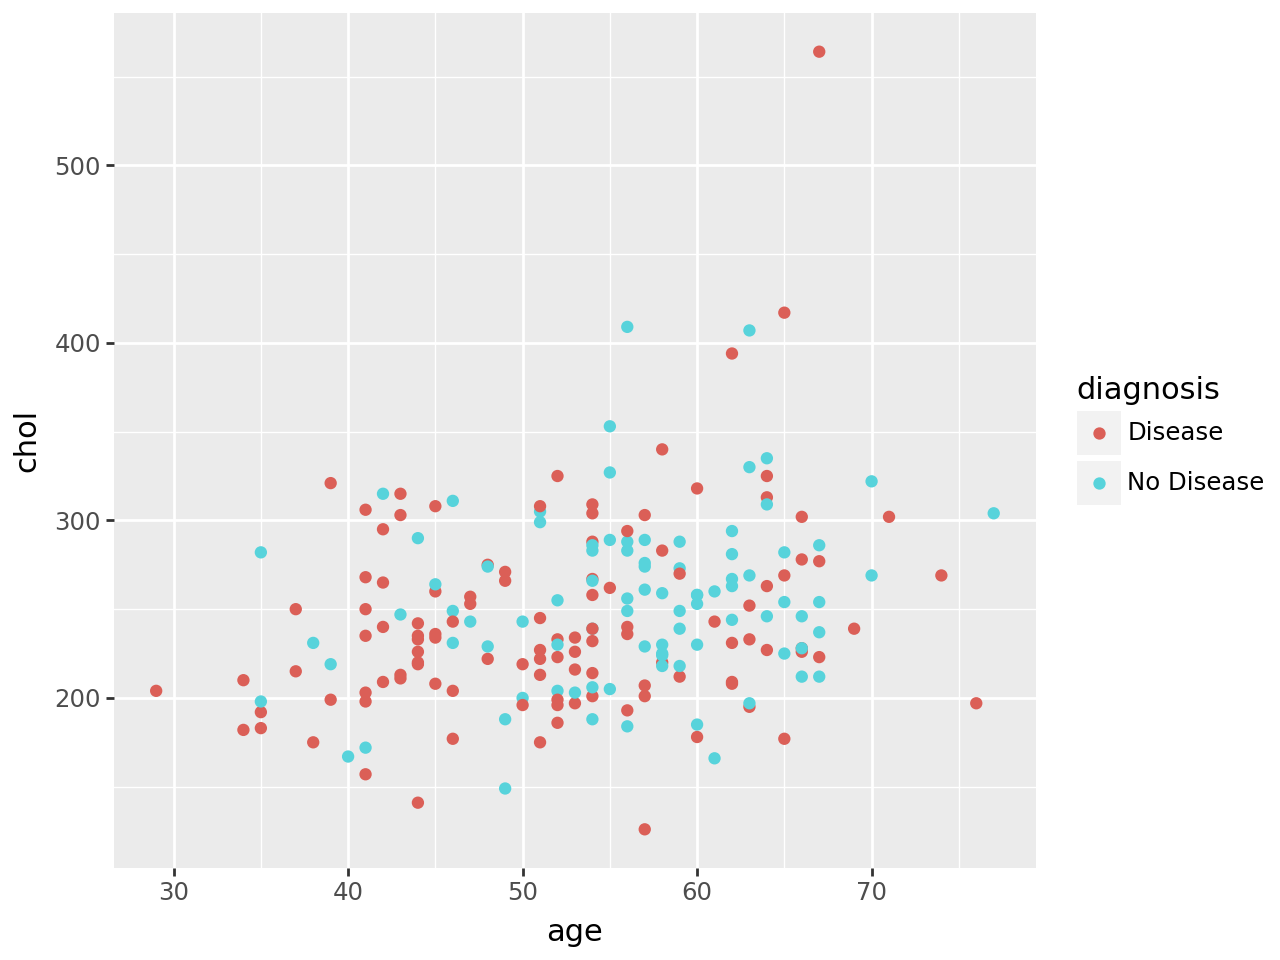

In [5]:
(ggplot(df, aes(x="age", y="chol", color="diagnosis"))
+ geom_point())

In [6]:
df[["age", "chol"]].describe()

,age,chol
count,204.000000,204.000000
mean,53.813725,248.377451
std,9.354781,53.176624
min,29.000000,126.000000
25%,46.000000,212.750000
50%,54.000000,241.000000
75%,61.000000,276.250000
max,77.000000,564.000000


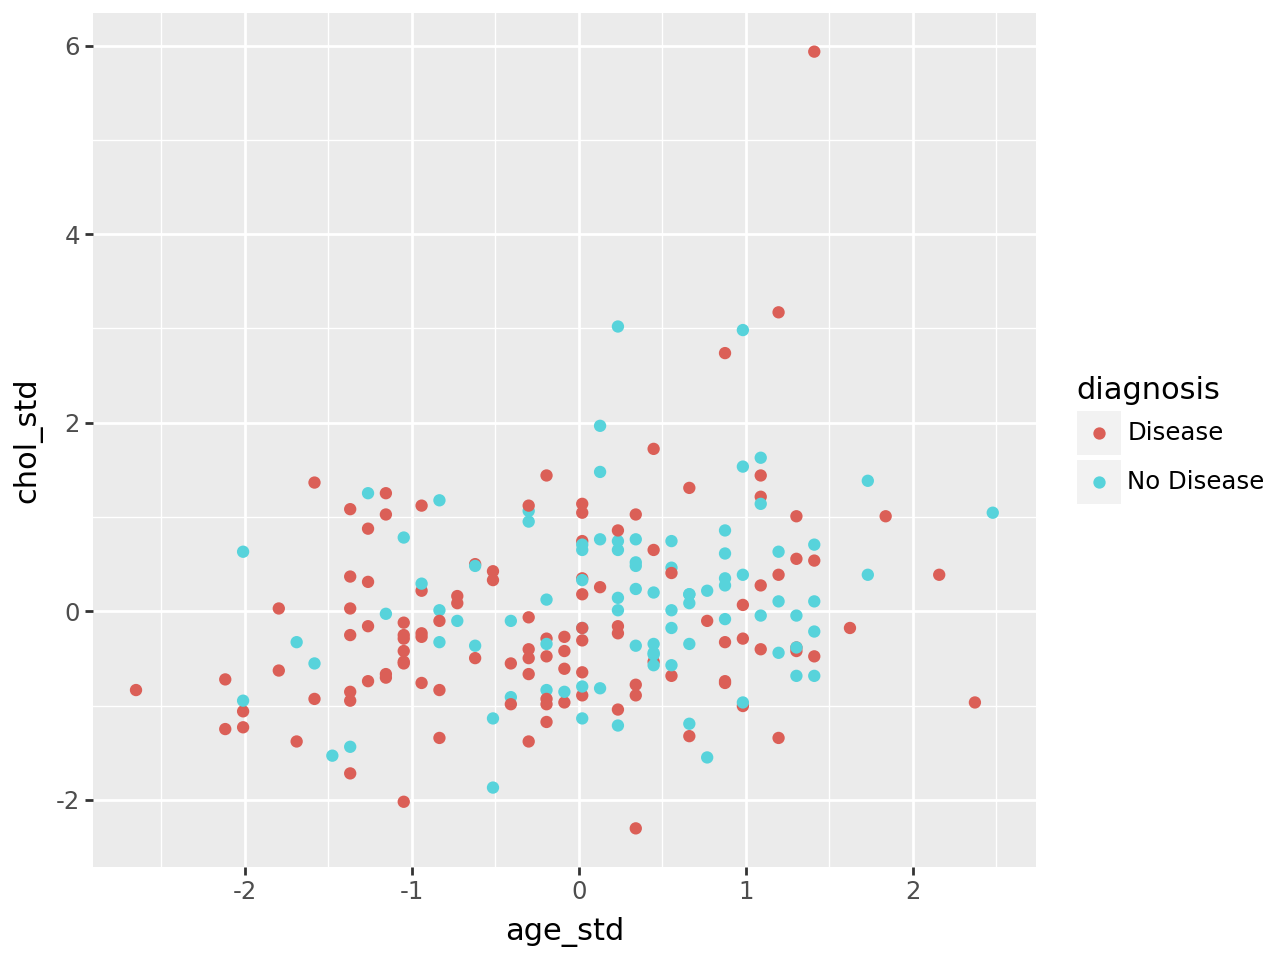

In [7]:
df["age_std"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["chol_std"] = (df["chol"] - df["chol"].mean()) / df["chol"].std()

(ggplot(df, aes(x="age_std", y="chol_std", color="diagnosis"))
+ geom_point())

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [9]:
# Packages to use:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = df[['age', 'chol']]
y = df['diagnosis']

logistic_model = Pipeline(
  [("standardize", StandardScaler()),
  ("logistic", LogisticRegression())]
)

logistic_model_fitted = logistic_model.fit(X, y)

logistic_model_fitted

,steps,"[('standardize', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [12]:
log_reg = logistic_model_fitted.named_steps["logistic"]
scaler  = logistic_model_fitted.named_steps["standardize"]

b_age, b_chol = log_reg.coef_[0]
b0 = log_reg.intercept_[0]

mu_age, mu_chol = scaler.mean_
sd_age, sd_chol = np.sqrt(scaler.var_)

def chol_for_prob_at_age(age, p):
    """Return raw cholesterol needed to reach probability p at given age."""
    logit = np.log(p/(1-p))
    z_age = (age - mu_age) / sd_age
    z_chol = (logit - b0 - b_age*z_age) / b_chol
    return z_chol * sd_chol + mu_chol

age = 55
chol_p50 = chol_for_prob_at_age(age, 0.5)  # decision boundary
chol_p90 = chol_for_prob_at_age(age, 0.9)  # 90% probability

print(f"For a {age}-year-old:")
print(f" Cholesterol ≈ {chol_p50:.1f} mg/dL at the decision boundary (p=0.5).")
print(f" Cholesterol ≈ {chol_p90:.1f} mg/dL for a 90% predicted chance of disease.")



For a 55-year-old:
 Cholesterol ≈ 367.7 mg/dL at the decision boundary (p=0.5).
 Cholesterol ≈ 1582.1 mg/dL for a 90% predicted chance of disease.


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

lda_model = Pipeline([
    ("scale", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])
lda_model.fit(X, y)

lda = lda_model.named_steps["lda"]
scaler = lda_model.named_steps["scale"]

b_age, b_chol = lda.coef_[0]
b0 = lda.intercept_[0]
mu_age, mu_chol = scaler.mean_
sd_age, sd_chol = np.sqrt(scaler.var_)

def chol_for_lda(age):
    z_age = (age - mu_age) / sd_age
    chol_z = -(b0 + b_age * z_age) / b_chol
    return chol_z * sd_chol + mu_chol

age = 55
chol_lda = chol_for_lda(age)
print(f"For a {age}-year-old:")
print(f" - Cholesterol ≈ {chol_lda:.1f} mg/dL at the LDA decision boundary.")


For a 55-year-old:
 - Cholesterol ≈ 368.2 mg/dL at the LDA decision boundary.


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [14]:
from sklearn.svm import SVC

svc_model = Pipeline([
    ("scale", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1))  # C=1 is fine for simplicity
])
svc_model.fit(X, y)

svc = svc_model.named_steps["svc"]
scaler = svc_model.named_steps["scale"]

b_age, b_chol = svc.coef_[0]
b0 = svc.intercept_[0]
mu_age, mu_chol = scaler.mean_
sd_age, sd_chol = np.sqrt(scaler.var_)

def chol_for_svc(age):
    z_age = (age - mu_age) / sd_age
    chol_z = -(b0 + b_age * z_age) / b_chol
    return chol_z * sd_chol + mu_chol

chol_svc = chol_for_svc(age)
print(f"For a {age}-year-old:")
print(f" - Cholesterol ≈ {chol_svc:.1f} mg/dL at the SVC decision boundary.")


For a 55-year-old:
 - Cholesterol ≈ 312.7 mg/dL at the SVC decision boundary.


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

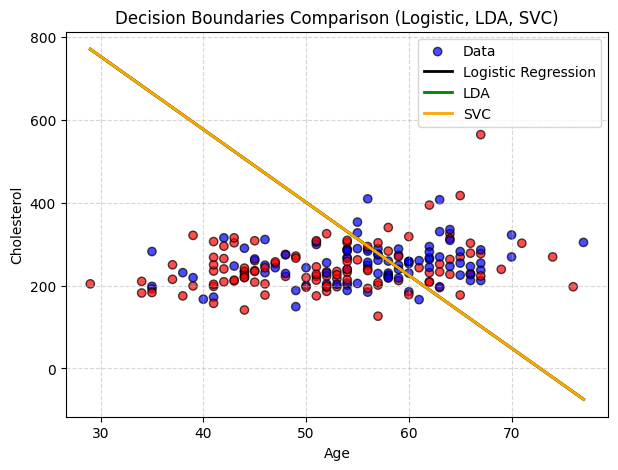

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define age range
ages = np.linspace(df["age"].min(), df["age"].max(), 100)

# Compute cholesterol boundaries for each model
chol_log = np.array([chol_for_prob_at_age(a, 0.5) for a in ages])
chol_lda = np.array([chol_for_lda(a) for a in ages])
chol_svc = np.array([chol_for_svc(a) for a in ages])

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(df["age"], df["chol"],
            c=(y == "Disease"), cmap="bwr", edgecolors="k", alpha=0.7, label="Data")

plt.plot(ages, chol_log, label="Logistic Regression", linewidth=2, color="black")
plt.plot(ages, chol_lda, label="LDA", linewidth=2, color="green")
plt.plot(ages, chol_svc, label="SVC", linewidth=2, color="orange")

plt.xlabel("Age")
plt.ylabel("Cholesterol")
plt.title("Decision Boundaries Comparison (Logistic, LDA, SVC)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

